In [149]:
import ddsp
import IPython.display as ipd
import soundfile as sf
# from ddsp.colab.colab_utils import play, specplot, DEFAULT_SAMPLE_RATE
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import tensorflow as tf
import io
from scipy.io import wavfile

In [116]:
n_frames = 1000
hop_size = 64
n_samples = n_frames * hop_size
sample_rate = 16000
harmonic = ddsp.synths.Harmonic(n_samples=n_samples, sample_rate=sample_rate)


In [150]:
# Aplitudes
amps = np.linspace(1.0, -3.0, n_frames)
amps = amps[np.newaxis,:, np.newaxis]
# Harmonic distribution
n_harmonics = 30
harmonic_distribution = (np.linspace(-2.0, 2.9, n_frames)[:, np.newaxis] + np.linspace(3.0, -3.0, n_harmonics)[np.newaxis, :])

print("AMPS:", amps.shape)

harmonic_distribution = harmonic_distribution[np.newaxis, :, :]
print(f"Reshaped Harmonic: {harmonic_distribution.shape}")
f_0_hz = 440.0 * np.ones([1, n_frames,1], dtype=np.float32) # Frequency in Hz
print(f"{f_0_hz.shape}")
time= np.linspace(0, n_samples/sample_rate, n_frames)
print(time.shape)

AMPS: (1, 1000, 1)
Reshaped Harmonic: (1, 1000, 30)
(1, 1000, 1)


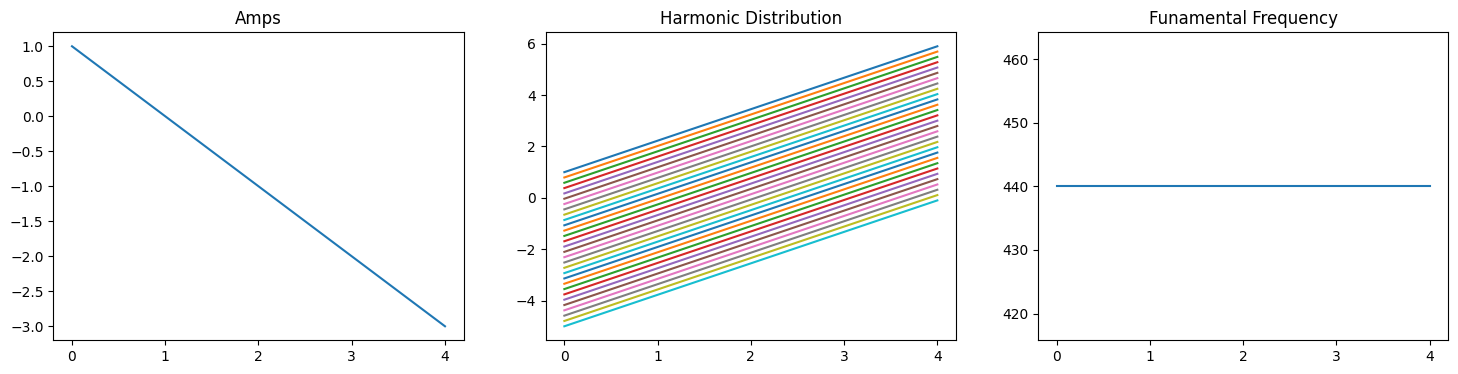

In [119]:
plt.figure(figsize=(18,4))
plt.subplot(131)
plt.plot(time, amps[0, :, 0])
plt.xticks(np.arange(0, 5).tolist())
plt.title("Amps")

plt.subplot(132)
plt.plot(time, harmonic_distribution[0, :, :])
plt.xticks(np.arange(0, 5).tolist())
plt.title("Harmonic Distribution")

plt.subplot(133)
plt.plot(time, f_0_hz[0, :, 0])
plt.xticks(np.arange(0, 5).tolist())
_ = plt.title("Funamental Frequency")

In [120]:
controls = harmonic.get_controls(amps, harmonic_distribution, f_0_hz)
print(controls.keys())

dict_keys(['amplitudes', 'harmonic_distribution', 'f0_hz'])


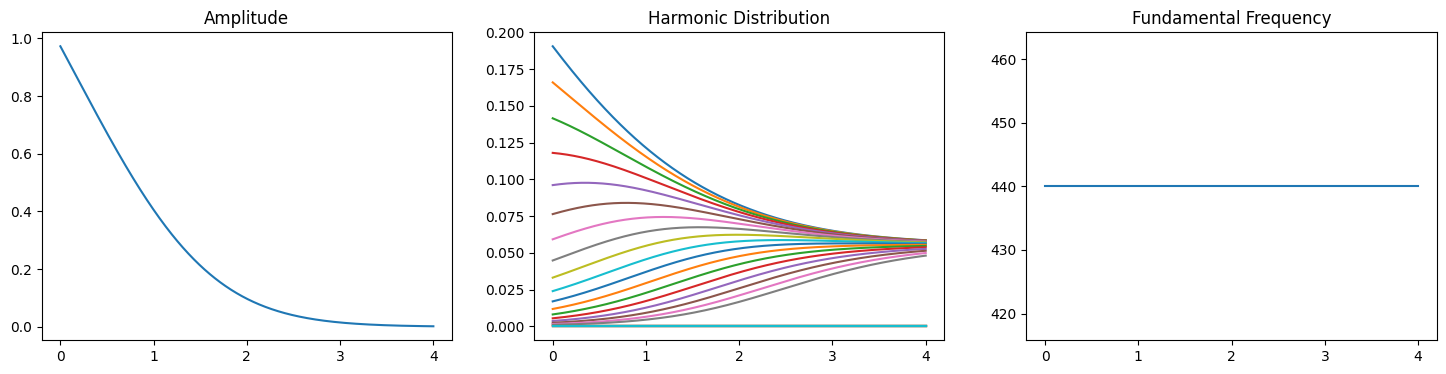

In [121]:
# Now let's see what they look like...
time = np.linspace(0, n_samples / sample_rate, n_frames)

plt.figure(figsize=(18, 4))
plt.subplot(131)
plt.plot(time, controls['amplitudes'][0, :, 0])
plt.xticks([0, 1, 2, 3, 4])
plt.title('Amplitude')

plt.subplot(132)
plt.plot(time, controls['harmonic_distribution'][0, :, :])
plt.xticks([0, 1, 2, 3, 4])
plt.title('Harmonic Distribution')

plt.subplot(133)
plt.plot(time, controls['f0_hz'][0, :, 0])
plt.xticks([0, 1, 2, 3, 4])
_ = plt.title('Fundamental Frequency')


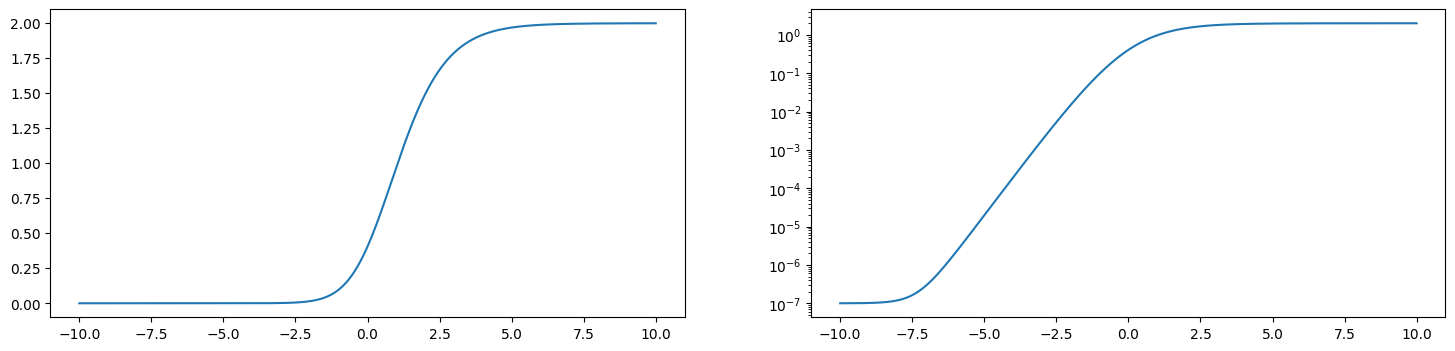

In [122]:
x = tf.linspace(-10.0, 10.0, 10000)
y = ddsp.core.exp_sigmoid(x)
plt.figure(figsize=(18, 4))
plt.subplot(121)
plt.plot(x,y)
plt.subplot(122)
_ = plt.semilogy(x,y)

In [151]:
audio = harmonic.get_signal(**controls)
print(audio.shape)
if len(audio.shape) == 2:
    array_of_floats = audio[0]

normalizer = float(np.iinfo(np.int16).max)
array_of_ints = np.array(np.asarray(array_of_floats) * normalizer)
print(array_of_ints.dtype)

with open("./data/test_whistle.wav", 'rb') as wvf:
    hi, rate = sf.read(wvf)
    time = np.linspace(0, len(hi) / rate, len(hi))
# ipd.Audio(hi, rate=rate)


(1, 64000)
float32


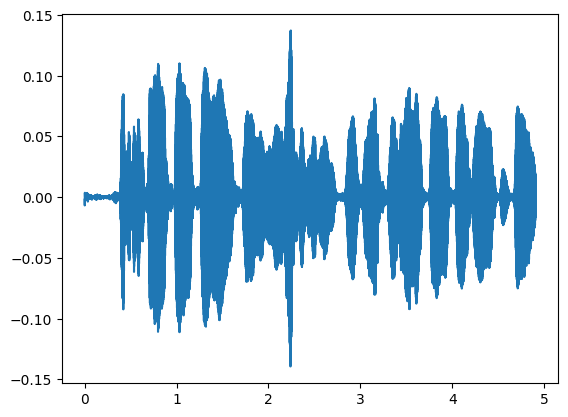

In [152]:
plt.plot(time,hi)